In [3]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v3 as iio
import os
import cv2


In [95]:
from timeit import default_timer
from contextlib import contextmanager

@contextmanager
def block_timer(prefix=""):
    beg_ts = default_timer()
    try:
        yield
    finally:
        print(f'Timer: {prefix} took {default_timer() - beg_ts:.5f} seconds...')

#### Center PSFs

In [409]:
data_path = '/Volumes/flamingo_data/_Salman/_calibration/Jan23_loft/dataset_jun23/p.0p0p0_p0p0p0/captures/l-n4n4p0'
psfs = [name for name in os.listdir(data_path) if 'g-circle4' in name and 'grid' not in name];

def get_reference_psf_location(im_ref, im_bg):
    ref_psf_loc = np.unravel_index(np.argmax(im_ref-im_bg, axis=None), (im_ref-im_bg).shape)
    return ref_psf_loc

def get_image_shift(im_psf, im_ref, im_bg, ref_psf_loc, method='peak'):
    psf_peak_val = np.max(im_psf-im_bg, axis=None)
    if method == 'peak':
        psf_peak = np.unravel_index(np.argmax(im_psf-im_bg, axis=None), (im_psf-im_bg).shape)
        ref_psf_loc = get_reference_psf_location(im_ref, im_bg)
        shift = np.array(psf_peak) - np.array(ref_psf_loc)
    elif method == 'phase':
        from skimage.registration import phase_cross_correlation    
        shift, _, _ = phase_cross_correlation(im_psf-im_bg, im_ref-im_bg2, upsample_factor=2)
    else:
        raise Exception('incorrect method for finding the shift between images')
    return shift, ref_psf_loc, psf_peak_val

def center_psf(data_path, psf_name, im_ref, im_bg, img_bg2, ref_psf_loc, good_thresh):
    im_psf = cv2.imread(os.path.join(data_path, psf_name), cv2.IMREAD_GRAYSCALE).astype(float)
    shift, ref_psf_loc, psf_peak_val = get_image_shift(im_psf, im_ref, im_bg, im_bg2, 'peak')

    import skimage.transform as tf
    transform = tf.AffineTransform(translation=np.flip(shift))
    psf_centered = tf.warp(im_psf, transform, mode='wrap', preserve_range=True)
    psf_centered_cleaned = np.zeros_like(im_psf, dtype=float)
    psf_centered_cleaned[ref_psf_loc[0]-8:ref_psf_loc[0]+9, ref_psf_loc[1]-8:ref_psf_loc[1]+9] = psf_centered[ref_psf_loc[0]-8:ref_psf_loc[0]+9, ref_psf_loc[1]-8:ref_psf_loc[1]+9]
    return psf_centered_cleaned, psf_peak_val > good_thresh

im_ref = cv2.imread(os.path.join(data_path, 'g-circle4-0-0.png'), cv2.IMREAD_GRAYSCALE).astype(float)
im_bg = iio.imread(os.path.join(data_path, 'black-circle4-1.png')).astype(float)
im_bg2 = iio.imread(os.path.join(data_path, 'black-circle4-2.png')).astype(float)
ref_psf_loc = get_reference_psf_location(im_ref, im_bg)

dict_centered_psfs = {psf.split('.png')[0]: center_psf(data_path, psf, im_ref, im_bg, im_bg2, ref_psf_loc, 20)[0] for psf in psfs if center_psf(data_path, psf, im_ref, im_bg, im_bg2, ref_psf_loc, 20)[1]}

#### Video of Centered PSFs

In [135]:
# plt.imshow(dict_centered_psfs['g-circle4-0-0'][ref_psf_loc[0]-50:ref_psf_loc[0]+50, ref_psf_loc[1]-50:ref_psf_loc[1]+50])
import cv2 
out = cv2.VideoWriter('/Volumes/flamingo_data/_Salman/_calibration/Jan23_loft/dataset_jun23/psfs_centered_2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 5, (100, 100), False)
for name, img in dict_centered_psfs.items():
    im = img[ref_psf_loc[0]-50:ref_psf_loc[0]+50, ref_psf_loc[1]-50:ref_psf_loc[1]+50].astype('uint8')
    cv2.putText(im, name, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, .4, (255, 255, 255), 1, cv2.LINE_AA)
    out.write(im)

out.release()

#### Compare shifts from Peak vs. Phase cross-correlation

In [136]:
im =  iio.imread('/Volumes/flamingo_data/_Salman/_calibration/Jan23_loft/dataset_jun23/p.0p0p0_p0p0p0/captures/l-n4n4p0/g-circle4-0-0.png').astype(float)
im1 = iio.imread('/Volumes/flamingo_data/_Salman/_calibration/Jan23_loft/dataset_jun23/p.0p0p0_p0p0p0/captures/l-n4n4p0/g-circle4-1-2.png').astype(float)
im2 = iio.imread('/Volumes/flamingo_data/_Salman/_calibration/Jan23_loft/dataset_jun23/p.0p0p0_p0p0p0/captures/l-n4n4p0/black-circle4-1.png').astype(float)
im3 = iio.imread('/Volumes/flamingo_data/_Salman/_calibration/Jan23_loft/dataset_jun23/p.0p0p0_p0p0p0/captures/l-n4n4p0/black-circle4-2.png').astype(float)

from skimage.registration import phase_cross_correlation
shift, error, diffphase = phase_cross_correlation(im1-im3, im-im2, upsample_factor=10)
print(shift)

#Verify Shift calculated by Phase Cross Correlation
im_diff_up = cv2.resize(im-im2, np.array(im.shape)*2, interpolation=cv2.INTER_NEAREST)
im1_diff_up = cv2.resize(im1-im2, np.array(im.shape)*2, interpolation=cv2.INTER_NEAREST)

# im_diff_up = cv2.pyrUp(im-im2, dstsize=np.array(im.shape)*2)
# im1_diff_up = cv2.pyrUp(im1-im2, dstsize=np.array(im.shape)*2)
psf1_loc = np.array(np.unravel_index(np.argmax(im_diff_up, axis=None), np.array(im.shape)*2))/2
psf2_loc = np.array(np.unravel_index(np.argmax(im1_diff_up, axis=None), np.array(im.shape)*2))/2
print(np.array(psf2_loc)-np.array(psf1_loc))

[-220.3  359.1]
[-220. -163.]


#### Blur using PSF

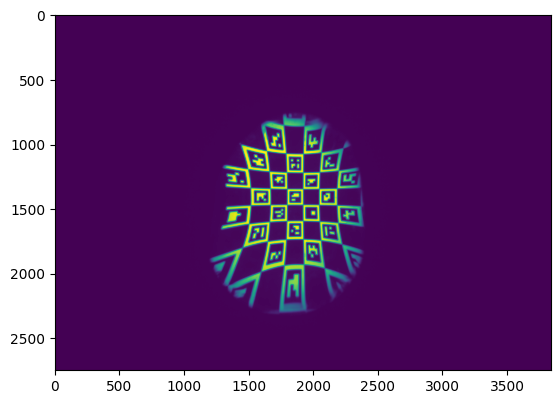

In [430]:
from scipy import fft, signal

def my_convolve(im, psf):
    pd_ht = int((im.shape[0]-psf.shape[0])//2)
    pd_wd = int((im.shape[1]-psf.shape[1])//2)
    psf_centered_padd = np.pad(psf, ((pd_ht, im.shape[0]-(psf.shape[0]+pd_ht)),
                                    (pd_wd, im.shape[1]-(psf.shape[1]+pd_wd))))
    return fft.fftshift(fft.ifft2(fft.fft2(im)*fft.fft2(psf_centered_padd)).real)
def convolve(im, psf):
    return signal.fftconvolve(im, psf, mode='same')

im = cv2.imread('/Volumes/flamingo_data/_Salman/_calibration/Jan23_loft/dataset_jun23/p.0p0p0_p0p0p0/captures/l-n4n4p0/g-charuco.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
# psf = np.zeros((17, 17)); psf[8:9, 8:9] = 1 #ideal PSF
psf = list(dict_centered_psfs.values())[8][ref_psf_loc[0]-8:ref_psf_loc[0]+9, ref_psf_loc[1]-8:ref_psf_loc[1]+9]

im_blur = convolve(im, psf)
plt.imshow(im_blur); plt.show()

#### Forward Model of Flicker and Rigaut

In [431]:
from scipy import linalg
from skimage import transform

def forward_blur(im, psfs, k=3):
    im_final = np.zeros_like(im, dtype=float)

    for psf in psfs:
        # with block_timer('computing SVD'):
        U, s, Vh = linalg.svd(psf, full_matrices=False)

        for i in range(k):
            # with block_timer('computing forward pass'):
            weight = np.pad((s[i]*Vh[i, :])[None,:], ((0,im.shape[0]-1), (0,0)))
            psf_mode = np.pad(U[:,i][:,None], ((0,0), (0, im.shape[1]-1)))

            im_final += convolve(im * weight, psf_mode)
    
    return im_final.flatten()

# im_final = forward_blur(im.flatten().reshape(*im.shape), dict_centered_psfs.values())
# plt.imshow(im_final.reshape(*im.shape))
    

In [432]:
from scipy import optimize, linalg

def cost_function(x, im, psfs, im_shape, Nfeval):
    im_blur = forward_blur(x.reshape(*im_shape), psfs)
    error = linalg.norm(im_blur - im)**2

    print("{0:4d} {1: 3.6f}".format(Nfeval, error))
    Nfeval +=1 

    return error

im_init = np.random.randn(*im.shape).astype(np.float32)
im_init = transform.resize(im_init, np.array(im.shape)/3)
psfs = [transform.resize(psf, np.array(im.shape)/3) for psf in dict_centered_psfs.values()]
im = transform.resize(im, np.array(im.shape)/3)

im_opt = optimize.minimize(cost_function, x0=im.flatten(), args = (im.flatten(), psfs, im.shape, 0), 
                        method = 'BFGS', options = {'maxiter': 1, 'disp': True})

   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744.730972
   0  1960269744

KeyboardInterrupt: 

#### Verify Matrix multiplication

In [103]:
xx = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0]])
yy = np.array([[1, 1, 1], [0, 0, 0], [0, 0, 0]])
xx1 = np.array([[1, 1, 1]]).T
yy1 = np.array([[1, 1, 1]])
print(xx)
print(yy)
print(xx1)
print(yy1)
print(np.matmul(xx, yy))
print(np.matmul(xx1, yy1))
print(xx*yy)

[[1 0 0]
 [1 0 0]
 [1 0 0]]
[[1 1 1]
 [0 0 0]
 [0 0 0]]
[[1]
 [1]
 [1]]
[[1 1 1]]
[[1 1 1]
 [1 1 1]
 [1 1 1]]
[[1 1 1]
 [1 1 1]
 [1 1 1]]
[[1 0 0]
 [0 0 0]
 [0 0 0]]


In [74]:
np.pad(yy1, ((0,2),(0,0)))

array([[1, 1, 1],
       [0, 0, 0],
       [0, 0, 0]])